# K-means implementation

In [ ]:
def kmeans():
    # Passo 1: Fornece valores iniciais para os centroides e agrupa
    #         o restante dos dados em um centroide
    # Passo 2: Gera uma matriz de distancia entre cada ponto e 
    #         os centroides (N x k)
    # Passo 3: Coloca cada ponto nas classes que está mais próximo
    # Passo 4: Calcula os novos centroides para cada classe com a média
    # Passo 5: Repete o passo 2 em diante até convergir

In [4]:
!pip install matplotlib
!pip install numpy
!pip install pandas

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot
ERROR: No matching distribution found for matplotlib.pyplot


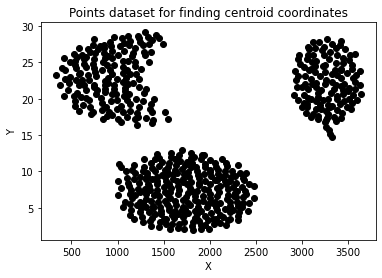

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_table("cluster.dat", sep=" ")
X = dataset.iloc[:, 0:1].values
Y = dataset.iloc[:, 1:2].values

plt.scatter(X, Y, label = "Point (X;Y)", color = 'k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Points dataset for finding centroid coordinates")
plt.show()